In [1]:
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import math
import random
import datetime as dt
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error



Import Data

In [2]:
df = pd.read_csv('C:/Users/yolau/OneDrive/Documents/TA/Kodingan/BBCA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-18,4180.0,4220.0,4170.0,4220.0,3802.38208,76474000
1,2017-12-19,4190.0,4250.0,4190.0,4220.0,3802.38208,76553500
2,2017-12-20,4210.0,4210.0,4175.0,4185.0,3770.84668,102963500
3,2017-12-21,4190.0,4230.0,4190.0,4220.0,3802.38208,61100000
4,2017-12-22,4235.0,4335.0,4195.0,4300.0,3874.46582,94573000


In [3]:
specific_df = df[['Date', 'Close', 'Open', 'High', 'Low']]

In [4]:
specific_df

,Date,Close,Open,High,Low
0,2017-12-18,4220.0,4180.0,4220.0,4170.0
1,2017-12-19,4220.0,4190.0,4250.0,4190.0
2,2017-12-20,4185.0,4210.0,4210.0,4175.0
3,2017-12-21,4220.0,4190.0,4230.0,4190.0
4,2017-12-22,4300.0,4235.0,4335.0,4195.0
...,...,...,...,...,...
1489,2023-12-08,8750.0,8800.0,8850.0,8750.0
1490,2023-12-11,8750.0,8675.0,8775.0,8675.0
1491,2023-12-12,8700.0,8700.0,8750.0,8700.0
1492,2023-12-13,8675.0,8700.0,8750.0,8675.0


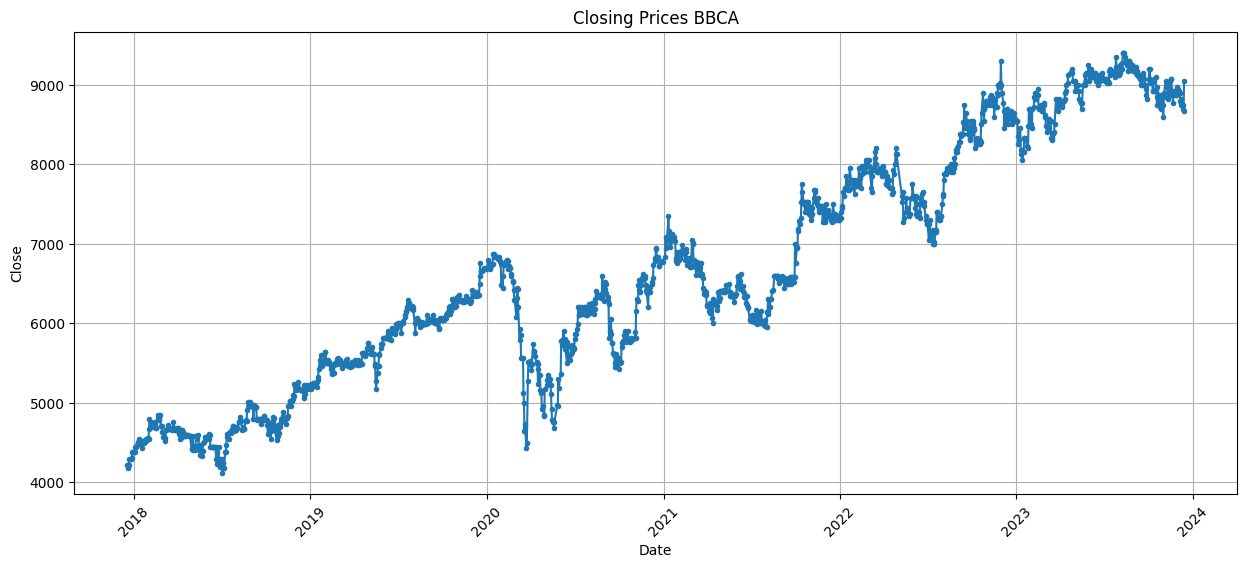

In [5]:
specific_df['Date'] = pd.to_datetime(specific_df['Date'])

plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], marker='.')
plt.title('Closing Prices BBCA')
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

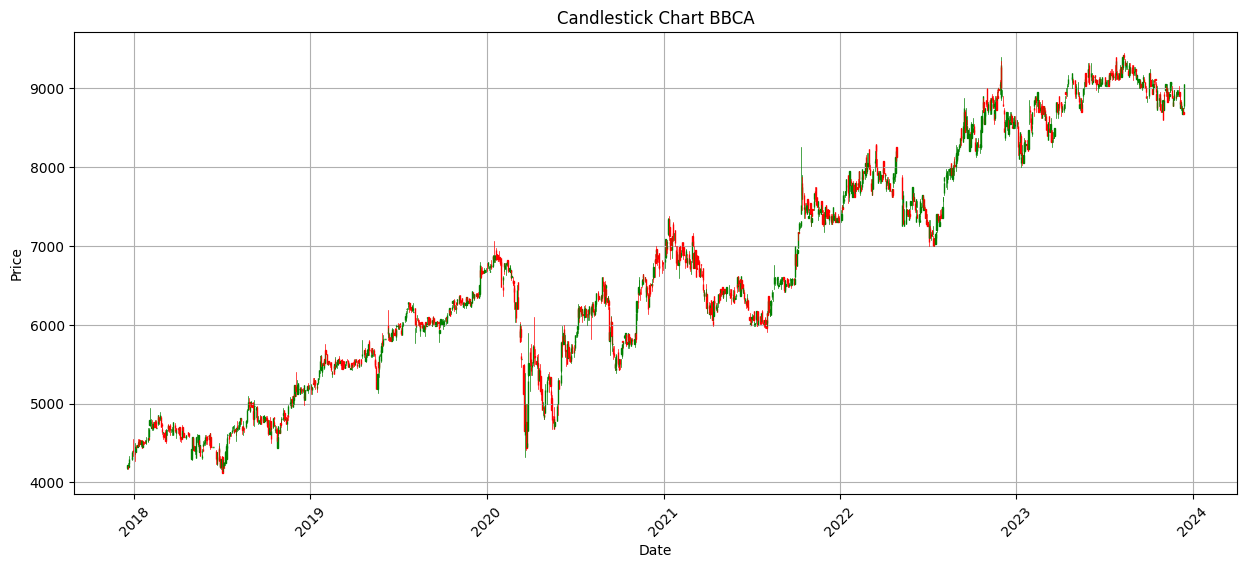

In [6]:
matplotlib_date = mdates.date2num(specific_df['Date'])

ohlc = np.vstack((matplotlib_date, specific_df['Open'], specific_df['High'], specific_df['Low'], specific_df['Close'])).T

plt.figure(figsize=(15,6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart BBCA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

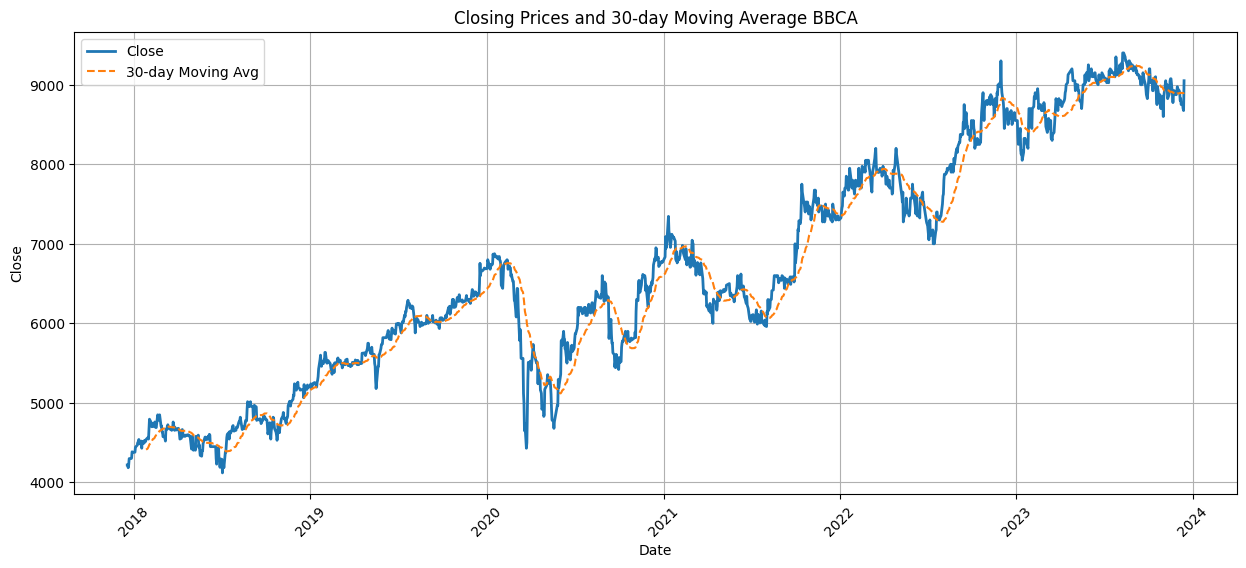

In [7]:
window = 30
plt.figure(figsize=(15,6))
plt.plot(specific_df['Date'], specific_df['Close'], label='Close', linewidth=2)
plt.plot(specific_df['Date'], specific_df['Close'].rolling(window=window).mean(),label=f'{window}-day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-day Moving Average BBCA')
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [8]:
specific_df.head()

,Date,Close,Open,High,Low
0,2017-12-18,4220.0,4180.0,4220.0,4170.0
1,2017-12-19,4220.0,4190.0,4250.0,4190.0
2,2017-12-20,4185.0,4210.0,4210.0,4175.0
3,2017-12-21,4220.0,4190.0,4230.0,4190.0
4,2017-12-22,4300.0,4235.0,4335.0,4195.0


In [9]:
new_df = specific_df.reset_index()['Close']

In [10]:
new_df

0       4220.0
1       4220.0
2       4185.0
3       4220.0
4       4300.0
         ...  
1489    8750.0
1490    8750.0
1491    8700.0
1492    8675.0
1493    9050.0
Name: Close, Length: 1494, dtype: float64

In [11]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [14]:
data = scaled_data

top_20_data = data[:20]
print(top_20_data)

[[0.01893939]
 [0.01893939]
 [0.01231061]
 [0.01893939]
 [0.03409091]
 [0.03409091]
 [0.03409091]
 [0.03503788]
 [0.05018939]
 [0.04924242]
 [0.04924242]
 [0.04924242]
 [0.04924242]
 [0.06155303]
 [0.0625    ]
 [0.06628788]
 [0.07291667]
 [0.07007576]
 [0.07954545]
 [0.06912879]]


Partisi Data

90%

In [12]:
train_size = int(len(scaled_data)*0.9) #90% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [13]:
n_past = 60

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [14]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1284, 60)
(1284,)


Testing set size:-
(90, 60)
(90,)


(None, None)

In [15]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [16]:
Layer = 3

In [17]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50))
model.add(Dropout(0.9))

model.add(Dense(units=1))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [19]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [20]:
checkpoints = ModelCheckpoint(filepath= 'bbca.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100

41/41 [==============================] - 7s 70ms/step - loss: 0.1032 - val_loss: 0.0931
Epoch 2/100
41/41 [==============================] - 2s 47ms/step - loss: 0.0626 - val_loss: 0.0492
Epoch 3/100
41/41 [==============================] - 2s 46ms/step - loss: 0.0506 - val_loss: 0.0447
Epoch 4/100
41/41 [==============================] - 2s 46ms/step - loss: 0.0498 - val_loss: 0.0164
Epoch 5/100
41/41 [==============================] - 2s 43ms/step - loss: 0.0400 - val_loss: 0.0403
Epoch 6/100
41/41 [==============================] - 2s 42ms/step - loss: 0.0352 - val_loss: 0.0537
Epoch 7/100
41/41 [==============================] - 2s 40ms/step - loss: 0.0336 - val_loss: 0.0420
Epoch 8/100
41/41 [==============================] - 2s 39ms/step - loss: 0.0292 - val_loss: 0.0276
Epoch 9/100
41/41 [==============================] - 2s 39ms/step - loss: 0.0266 - val_loss: 0.0196
Epoch 10/100
41/41 [==============================] - 2s 41ms/step - loss: 0.0220 - val_loss: 0.016

In [21]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

3/3 [==============================] - 0s 8ms/step


In [22]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [23]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.049770664356946555
0.032721271777659586


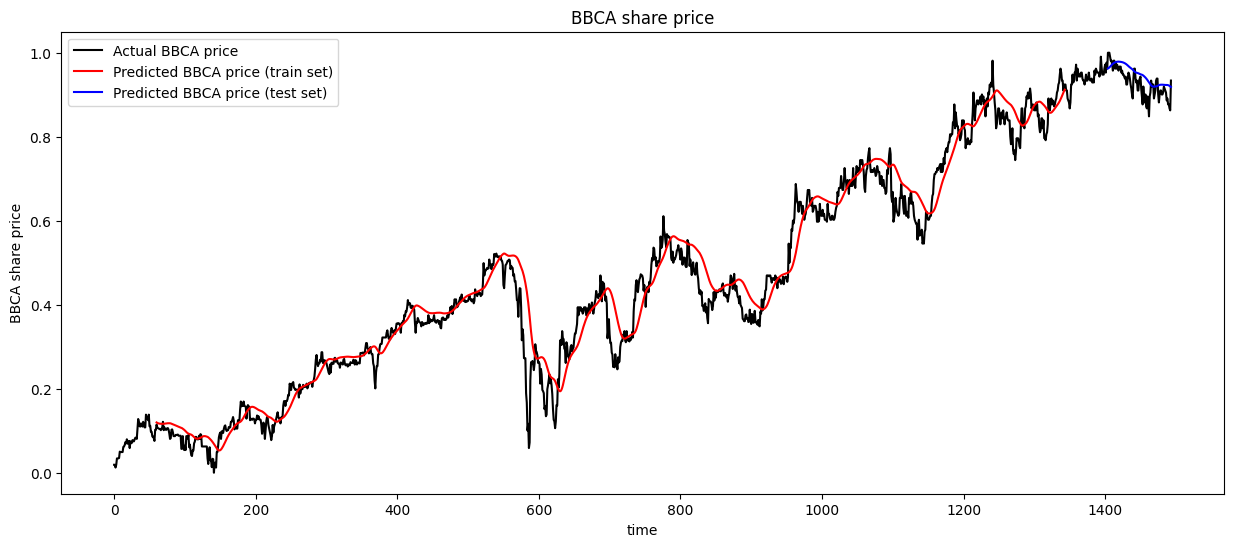

In [24]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual BBCA price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted BBCA price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted BBCA price (test set)")

plt.title(f"BBCA share price")
plt.xlabel("time")
plt.ylabel(f"BBCA share price")
plt.legend()
plt.show()

In [25]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 16ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 8969.109375
Day 2: Predicted Price = 8961.8056640625
Day 3: Predicted Price = 8956.5185546875
Day 4: Predicted Price = 8953.458984375
Day 5: Predicted Price = 8952.4482421875
Day 6: Predicted Price = 8953.1357421875
Day 7: Predicted Price = 8955.1689453125
Day 8: Predicted Price = 8958.205078125
Day 9: Predicted Price = 8961.8427734375
Day 10: Predicted Price = 8965.92578125
Day 11: Predicted Price = 8970.3408203125
Day 12: Predicted Price = 8975.0185546875
Day 13: Predicted Price = 8979.8349609375
Day 14: Predicted Price = 8984.6962890625
Day 15: Predicted Price = 8989.6259765625
Day 16: Predicted Price = 8994.541015625
Day 17: Predicted Price = 8999.376953125
Day 18: Predicted Price = 9004.16796875
Day 19: Predicted Price = 9008.912109375
Day 20: Predicted Price = 9013.6787109375
Day 21: Predicted Price = 9018.44140625
Day 22: Predicted Price = 9023.19921875
Day 23: Predicte

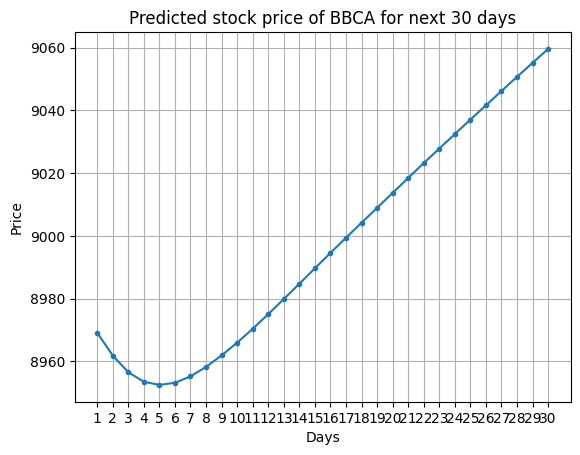

In [26]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of BBCA for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [27]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



3/3 [==============================] - 0s 19ms/step - loss: 0.0011
Validation Loss: 0.001070681493729353
Validation MSE Loss: 0.001070681493729353


In [28]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.049770664356946555
Testing RMSE: 0.032721271777659586


80%

In [29]:
train_size = int(len(scaled_data)*0.8) #80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [30]:
n_past = 60

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [31]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1135, 60)
(1135,)


Testing set size:-
(239, 60)
(239,)


(None, None)

In [32]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [33]:
Layer = 3

In [34]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50))
model.add(Dropout(0.9))

model.add(Dense(units=1))

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [36]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [37]:
checkpoints = ModelCheckpoint(filepath= 'bbca.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
36/36 [==============================] - 6s 70ms/step - loss: 0.0885 - val_loss: 0.0606
Epoch 2/100
36/36 [==============================] - 2s 51ms/step - loss: 0.0466 - val_loss: 0.0199
Epoch 3/100
36/36 [==============================] - 2s 43ms/step - loss: 0.0366 - val_loss: 0.0443
Epoch 4/100
36/36 [==============================] - 2s 43ms/step - loss: 0.0309 - val_loss: 0.0297
Epoch 5/100
36/36 [==============================] - 2s 47ms/step - loss: 0.0284 - val_loss: 0.0338
Epoch 6/100
36/36 [==============================] - 2s 51ms/step - loss: 0.0238 - val_loss: 0.0229
Epoch 7/100
36/36 [==============================] - 2s 50ms/step - loss: 0.0235 - val_loss: 0.0258
Epoch 8/100
36/36 [==============================] - 2s 49ms/step - loss: 0.0205 - val_loss: 0.0178
Epoch 9/100
36/36 [==============================] - 2s 59ms/step - loss: 0.0208 - val_loss: 0.0179
Epoch 10/100
36/36 [==============================] - 2s 59ms/step - loss: 0.0175 - val_loss: 0.0236

In [38]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

8/8 [==============================] - 0s 20ms/step


In [39]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [40]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.05382854295940042
0.07572074900383659


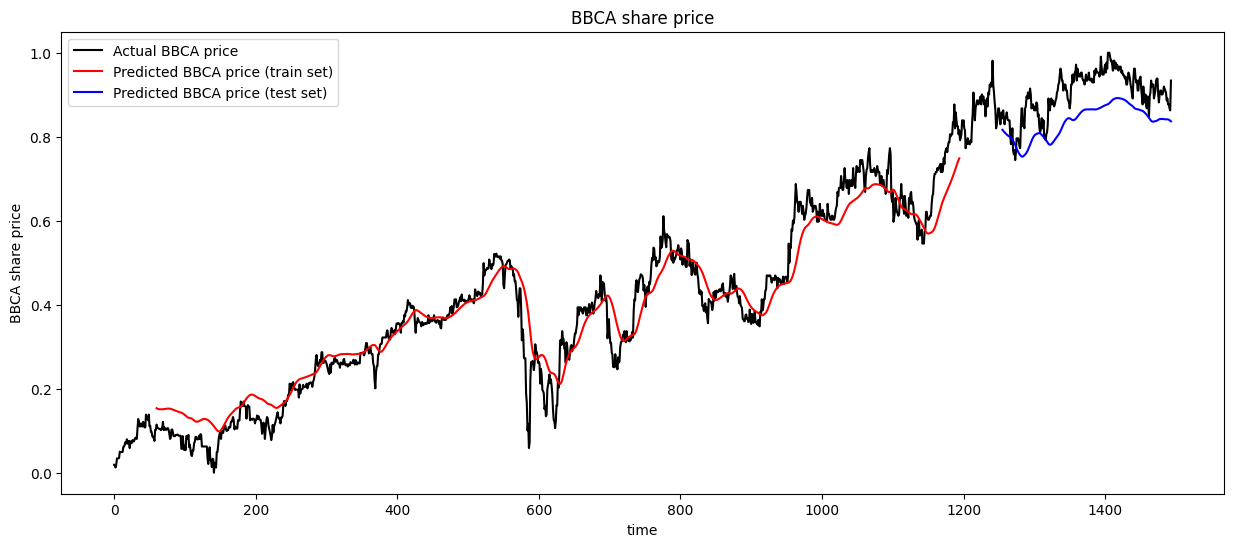

In [41]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual BBCA price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted BBCA price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted BBCA price (test set)")

plt.title(f"BBCA share price")
plt.xlabel("time")
plt.ylabel(f"BBCA share price")
plt.legend()
plt.show()

In [42]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 47ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 8537.41796875
Day 2: Predicted Price = 8526.560546875
Day 3: Predicted Price = 8513.2197265625
Day 4: Predicted Price = 8497.744140625
Day 5: Predicted Price = 8480.6103515625
Day 6: Predicted Price = 8462.2890625
Day 7: Predicted Price = 8443.197265625
Day 8: Predicted Price = 8423.6611328125
Day 9: Predicted Price = 8403.87890625
Day 10: Predicted Price = 8384.0517578125
Day 11: Predicted Price = 8364.3232421875
Day 12: Predicted Price = 8344.7890625
Day 13: Predicted Price = 8325.4765625
Day 14: Predicted Price = 8306.392578125
Day 15: Predicted Price = 8287.57421875
Day 16: Predicted Price = 8268.9951171875
Day 17: Predicted Price = 8250.6318359375
Day 18: Predicted Price = 8232.49609375
Day 19: Predicted Price = 8214.583984375
Day 20: Predicted Price = 8196.9169921875
Day 21: Predicted Price = 8179.47900390625
Day 22: Predicted Price = 8162.2607421875
Day 23: Predicted Pr

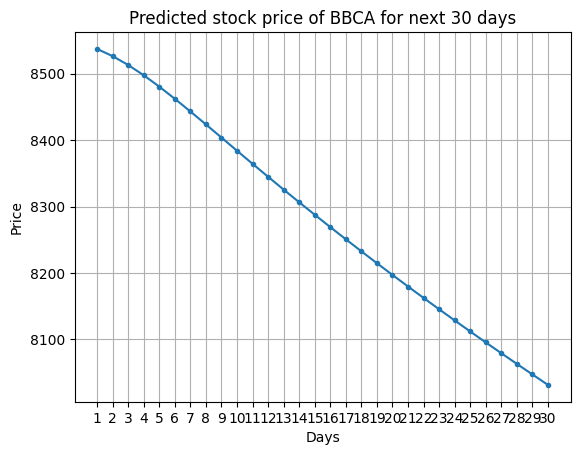

In [43]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of BBCA for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [44]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



8/8 [==============================] - 0s 21ms/step - loss: 0.0057
Validation Loss: 0.0057336315512657166
Validation MSE Loss: 0.0057336315512657166


In [45]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.05382854295940042
Testing RMSE: 0.07572074900383659


70%

In [46]:
train_size = int(len(scaled_data)*0.7) #70% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [47]:
n_past = 60

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [48]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(985, 60)
(985,)


Testing set size:-
(389, 60)
(389,)


(None, None)

In [49]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [50]:
Layer = 3

In [51]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50))
model.add(Dropout(0.9))

model.add(Dense(units=1))

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_6 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_7 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [53]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [54]:
checkpoints = ModelCheckpoint(filepath= 'bbca.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
31/31 [==============================] - 9s 102ms/step - loss: 0.0708 - val_loss: 0.1083
Epoch 2/100
31/31 [==============================] - 2s 54ms/step - loss: 0.0427 - val_loss: 0.0424
Epoch 3/100
31/31 [==============================] - 2s 63ms/step - loss: 0.0287 - val_loss: 0.0157
Epoch 4/100
31/31 [==============================] - 2s 58ms/step - loss: 0.0273 - val_loss: 0.0595
Epoch 5/100
31/31 [==============================] - 2s 61ms/step - loss: 0.0232 - val_loss: 0.0558
Epoch 6/100
31/31 [==============================] - 2s 60ms/step - loss: 0.0195 - val_loss: 0.0319
Epoch 7/100
31/31 [==============================] - 2s 65ms/step - loss: 0.0196 - val_loss: 0.0475
Epoch 8/100
31/31 [==============================] - 2s 67ms/step - loss: 0.0163 - val_loss: 0.0292
Epoch 9/100
31/31 [==============================] - 2s 65ms/step - loss: 0.0157 - val_loss: 0.0196
Epoch 10/100
31/31 [==============================] - 2s 73ms/step - loss: 0.0142 - val_loss: 0.046

In [55]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

13/13 [==============================] - 0s 20ms/step


In [56]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [57]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.05365462316087106
0.09728693710375909


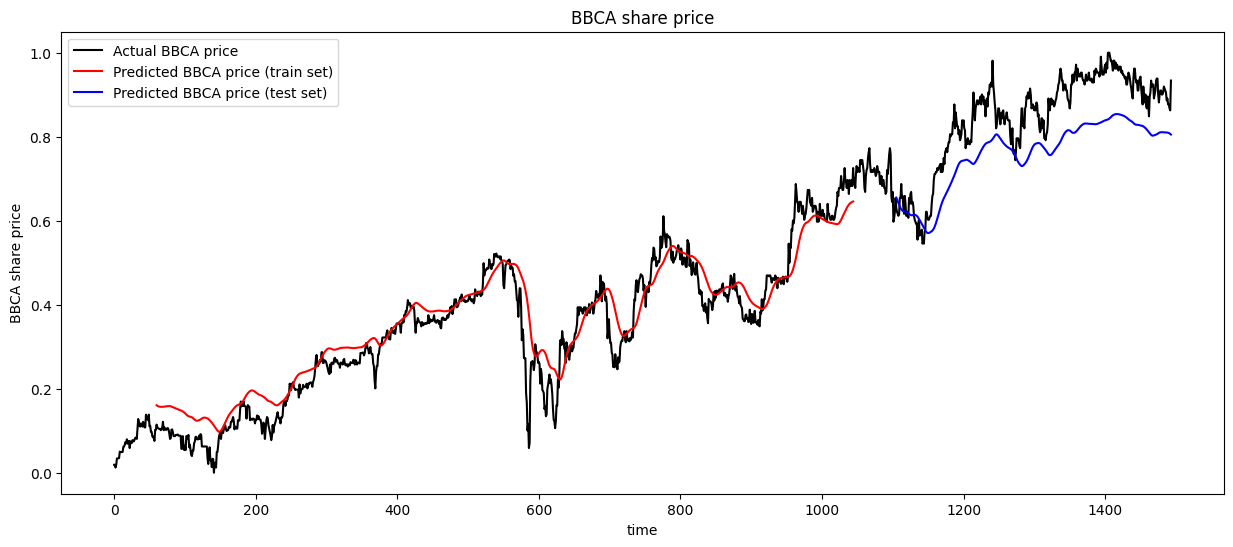

In [58]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual BBCA price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted BBCA price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted BBCA price (test set)")

plt.title(f"BBCA share price")
plt.xlabel("time")
plt.ylabel(f"BBCA share price")
plt.legend()
plt.show()

In [59]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 27ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 8371.619140625
Day 2: Predicted Price = 8359.9619140625
Day 3: Predicted Price = 8344.240234375
Day 4: Predicted Price = 8324.7890625
Day 5: Predicted Price = 8302.2958984375
Day 6: Predicted Price = 8277.5546875
Day 7: Predicted Price = 8251.31640625
Day 8: Predicted Price = 8224.2138671875
Day 9: Predicted Price = 8196.7412109375
Day 10: Predicted Price = 8169.27978515625
Day 11: Predicted Price = 8142.09814453125
Day 12: Predicted Price = 8115.37744140625
Day 13: Predicted Price = 8089.22021484375
Day 14: Predicted Price = 8063.6796875
Day 15: Predicted Price = 8038.7861328125
Day 16: Predicted Price = 8014.53662109375
Day 17: Predicted Price = 7990.91162109375
Day 18: Predicted Price = 7967.8984375
Day 19: Predicted Price = 7945.47216796875
Day 20: Predicted Price = 7923.6181640625
Day 21: Predicted Price = 7902.30810546875
Day 22: Predicted Price = 7881.52001953125
Day 23

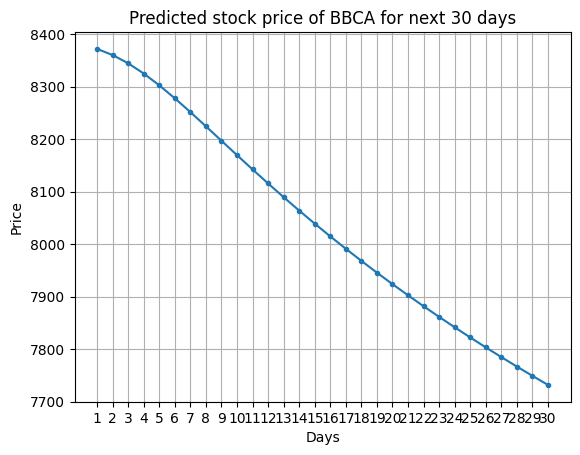

In [60]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of BBCA for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [61]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



13/13 [==============================] - 0s 20ms/step - loss: 0.0095
Validation Loss: 0.009464748203754425
Validation MSE Loss: 0.009464748203754425


In [62]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')


Training RMSE: 0.05365462316087106
Testing RMSE: 0.09728693710375909


60%

In [63]:
train_size = int(len(scaled_data)*0.6) #60% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [64]:
n_past = 60

X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [65]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(836, 60)
(836,)


Testing set size:-
(538, 60)
(538,)


(None, None)

In [66]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [68]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.9))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.9))

model.add(LSTM(units=50))
model.add(Dropout(0.9))

model.add(Dense(units=1))

In [69]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 60, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [70]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [71]:
checkpoints = ModelCheckpoint(filepath= 'bbca.h5', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(X_train,y_train,
          validation_data=(X_test,y_test),
          epochs=100,
          batch_size=32,
          verbose=1,
          callbacks=[checkpoints,early_stopping])

Epoch 1/100
27/27 [==============================] - 18s 154ms/step - loss: 0.0593 - val_loss: 0.1437
Epoch 2/100
27/27 [==============================] - 2s 79ms/step - loss: 0.0308 - val_loss: 0.1038
Epoch 3/100
27/27 [==============================] - 2s 76ms/step - loss: 0.0263 - val_loss: 0.0679
Epoch 4/100
27/27 [==============================] - 2s 70ms/step - loss: 0.0220 - val_loss: 0.1084
Epoch 5/100
27/27 [==============================] - 2s 74ms/step - loss: 0.0193 - val_loss: 0.0566
Epoch 6/100
27/27 [==============================] - 2s 85ms/step - loss: 0.0187 - val_loss: 0.0608
Epoch 7/100
27/27 [==============================] - 2s 74ms/step - loss: 0.0154 - val_loss: 0.0310
Epoch 8/100
27/27 [==============================] - 2s 71ms/step - loss: 0.0157 - val_loss: 0.0491
Epoch 9/100
27/27 [==============================] - 2s 83ms/step - loss: 0.0141 - val_loss: 0.0400
Epoch 10/100
27/27 [==============================] - 2s 84ms/step - loss: 0.0130 - val_loss: 0.05

In [72]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

17/17 [==============================] - 0s 22ms/step


In [73]:
#train_predict=scaler.inverse_transform(train_predict)
#test_predict=scaler.inverse_transform(test_predict)


In [74]:
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

0.0565223488003474
0.1761019231820555


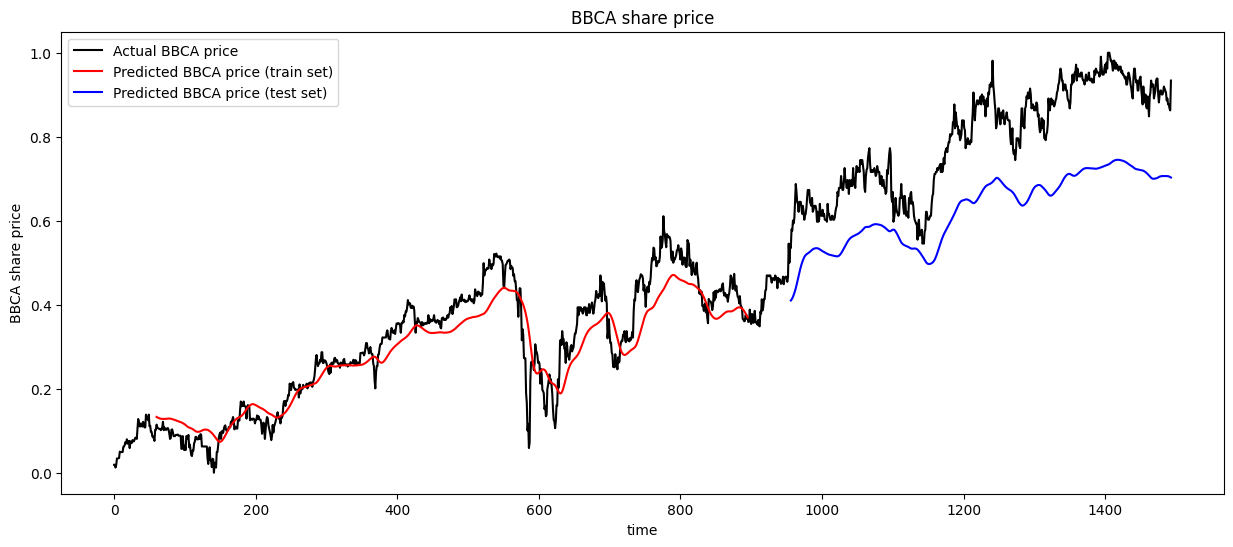

In [75]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back]= train_predict.flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot[test_start:]= test_predict.flatten()

plt.figure(figsize=(15,6))
plt.plot(scaled_data, color='black', label=f"Actual BBCA price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted BBCA price (train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted BBCA price (test set)")

plt.title(f"BBCA share price")
plt.xlabel("time")
plt.ylabel(f"BBCA share price")
plt.legend()
plt.show()

In [76]:
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

prediction_next_30_days = []

for _ in range(30):
    next_day_prediction = model.predict(last_sequence)
    prediction_next_30_days.append(next_day_prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = next_day_prediction

prediction_next_30_days = scaler.inverse_transform(np.array(prediction_next_30_days).reshape(-1, 1))

print("Predictions for the next 30 days:")
for i, prediction in enumerate(prediction_next_30_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")


1/1 [==============================] - 0s 79ms/step
Predictions for the next 30 days:
Day 1: Predicted Price = 7831.0615234375
Day 2: Predicted Price = 7819.72607421875
Day 3: Predicted Price = 7801.49560546875
Day 4: Predicted Price = 7776.1484375
Day 5: Predicted Price = 7744.3056640625
Day 6: Predicted Price = 7707.01806640625
Day 7: Predicted Price = 7665.47998046875
Day 8: Predicted Price = 7620.86083984375
Day 9: Predicted Price = 7574.20947265625
Day 10: Predicted Price = 7526.4111328125
Day 11: Predicted Price = 7478.1767578125
Day 12: Predicted Price = 7430.060546875
Day 13: Predicted Price = 7382.47021484375
Day 14: Predicted Price = 7335.6982421875
Day 15: Predicted Price = 7289.9404296875
Day 16: Predicted Price = 7245.3193359375
Day 17: Predicted Price = 7201.904296875
Day 18: Predicted Price = 7159.720703125
Day 19: Predicted Price = 7118.76708984375
Day 20: Predicted Price = 7079.0234375
Day 21: Predicted Price = 7040.455078125
Day 22: Predicted Price = 7003.02392578125


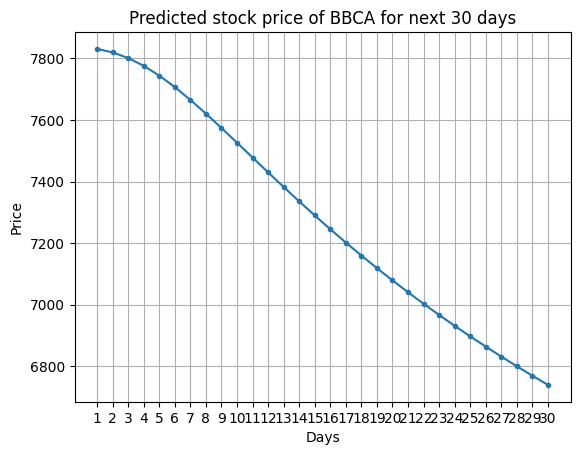

In [77]:
plt.plot(prediction_next_30_days, marker='.')
plt.title(f'Predicted stock price of BBCA for next 30 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 30), ['1','2','3','4','5','6','7','8','9','10',
                          '11','12','13','14','15','16','17','18','19','20',
                          '21','22','23','24','25','26','27','28','29','30'])
plt.grid(True)
plt.show()

In [78]:
# Evaluasi model
val_loss = model.evaluate(X_test, y_test)

print(f'Validation Loss: {val_loss}')

# Jika Anda memerlukan nilai MSE juga
val_mse = val_loss  # karena val_loss langsung berisi MSE
print(f'Validation MSE Loss: {val_mse}')



17/17 [==============================] - 0s 23ms/step - loss: 0.0310
Validation Loss: 0.03101188689470291
Validation MSE Loss: 0.03101188689470291


In [79]:
# Menghitung dan mencetak RMSE untuk data latih
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
print(f'Training RMSE: {train_rmse}')

# Menghitung dan mencetak RMSE untuk data uji
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 0.0565223488003474
Testing RMSE: 0.1761019231820555


: 